### How This Script Works:  Analysis of my dataset

Exploration: Shows basic info and class distribution

Histograms: Reveal the distribution of speed, acceleration, delta heading, and prediction error

Trajectory Plot: Shows the ship path; spoofed GPS points are highlighted in red

Time Series: Tracks speed and prediction error over time, making attacks visible

Correlation Heatmap: Identifies relationships between features, helping ML feature selection

Rolling Statistics: Smooth trends over 5-second windows, highlighting anomalies

Interactive Map: Shows real ship movement; spoofed points are clearly visualized

Columns: ['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'speed_calc', 'acceleration', 'delta_heading', 'speed_ma', 'acceleration_ma', 'delta_heading_ma', 'LAT_pred', 'LON_pred', 'prediction_error', 'Label']
        MMSI BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367109910   2020-01-01  47.65925 -122.37875  0.0  342.3     95.0   
1  338127175   2020-01-01  47.64416 -122.31557  0.0  360.0    511.0   
2  367186210   2020-01-01  36.83719  -76.29111  0.0  360.0    511.0   
3  367182980   2020-01-01  29.93012  -93.87452  7.3  219.3    511.0   
4  368111750   2020-01-01  29.37558  -94.88956  0.0  119.9    266.0   

   speed_calc  acceleration  delta_heading  speed_ma  acceleration_ma  \
0         0.0           NaN            0.0       0.0              NaN   
1         0.0           NaN            0.0       0.0              NaN   
2         0.0           NaN            0.0       0.0              NaN   
3         0.0           NaN            0.0       0.0     

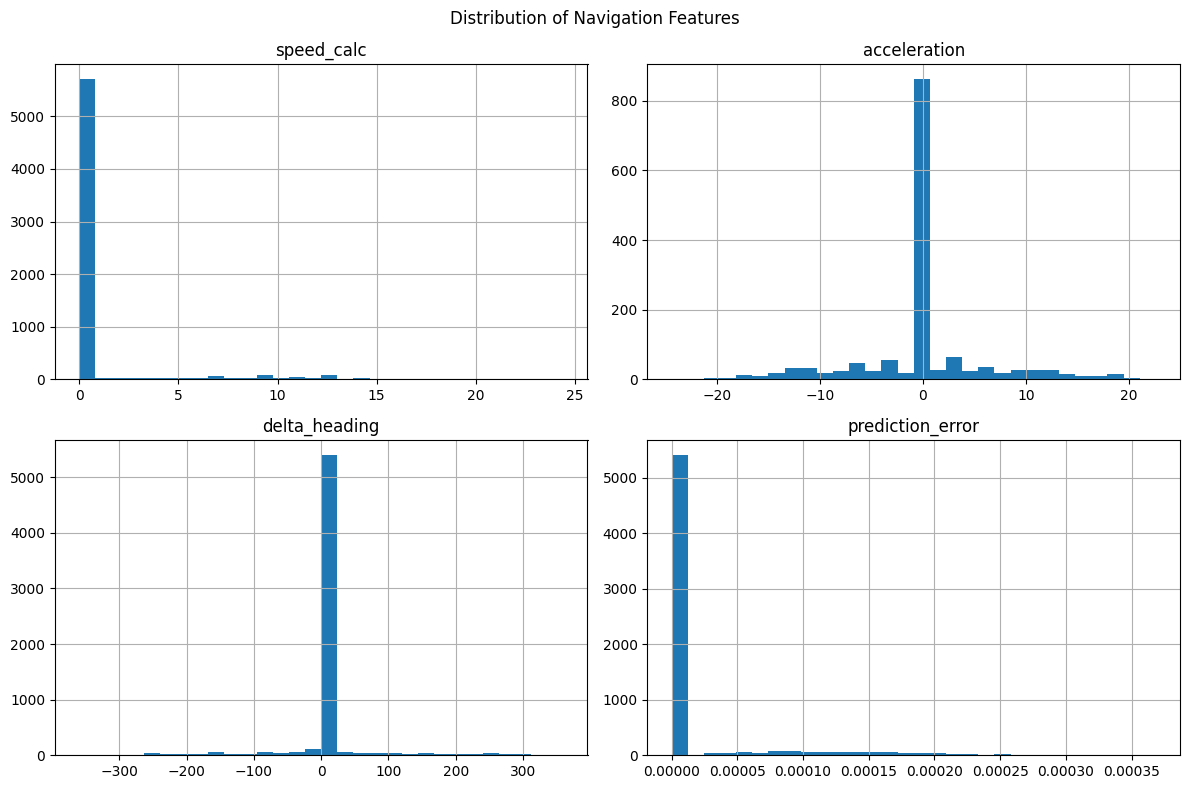

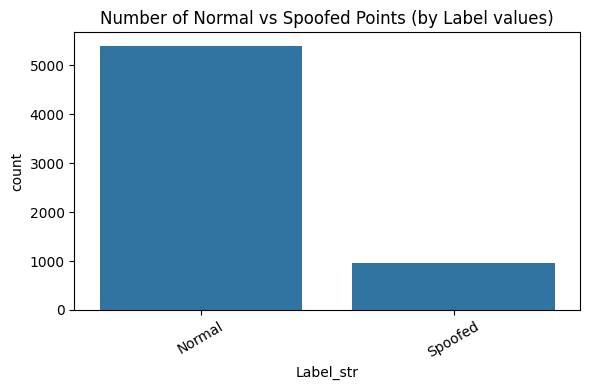

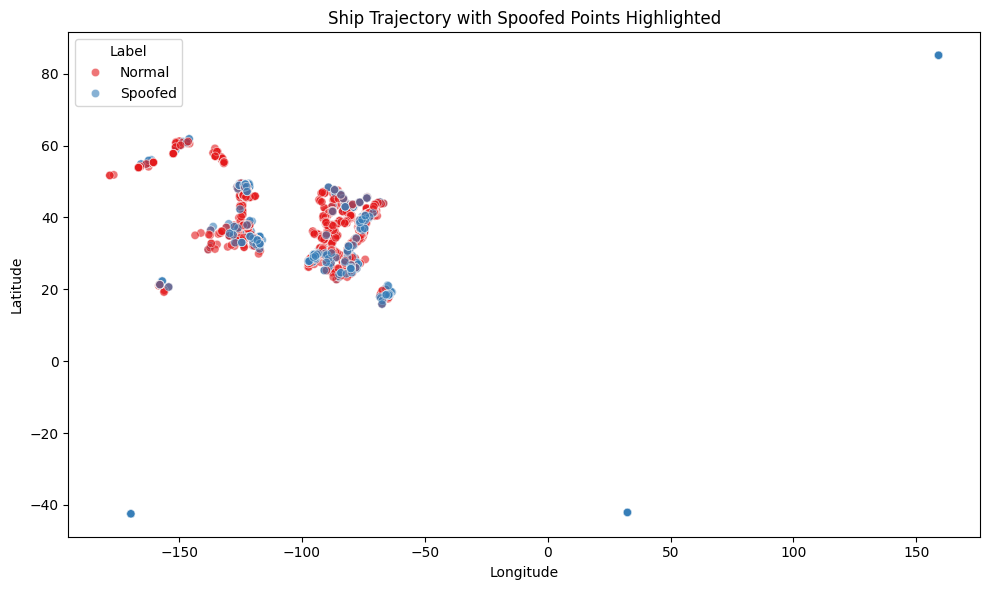

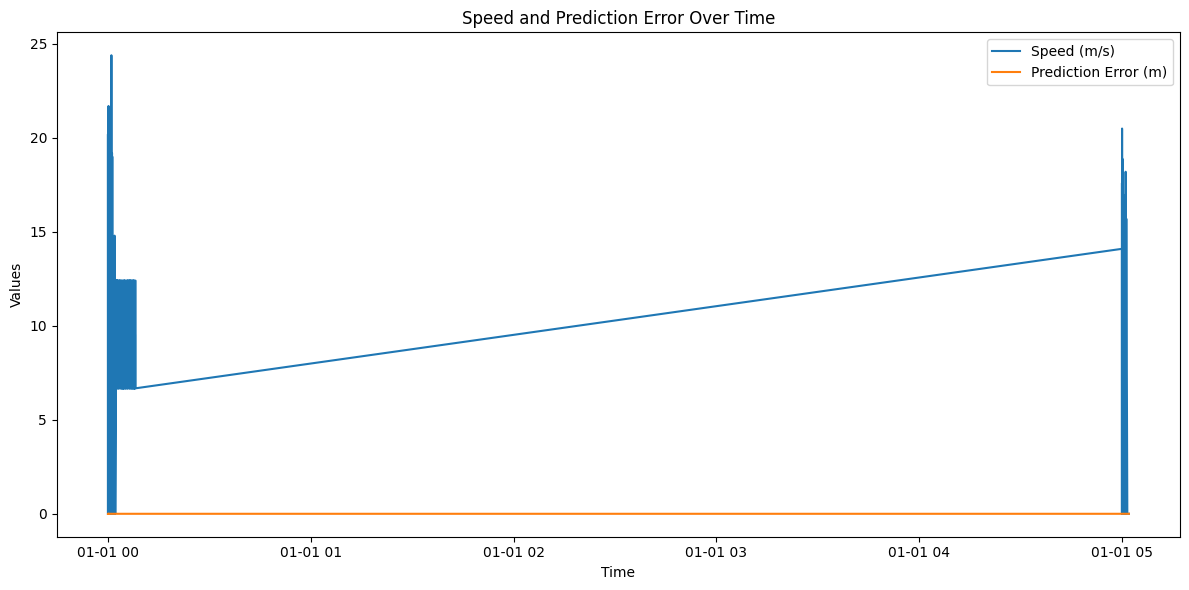

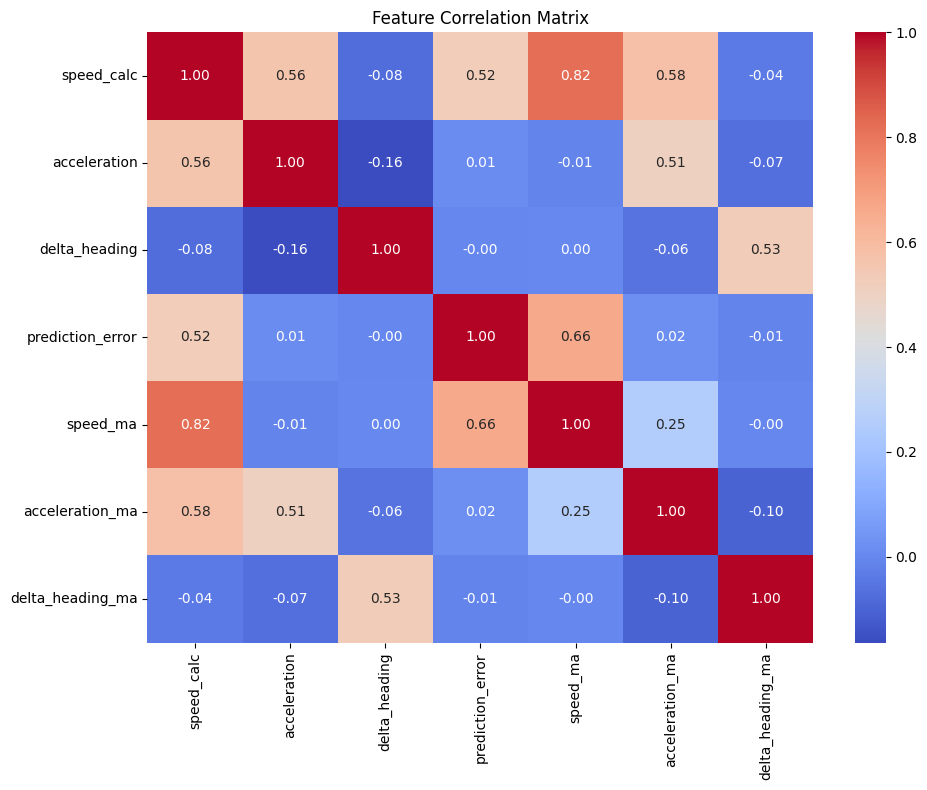

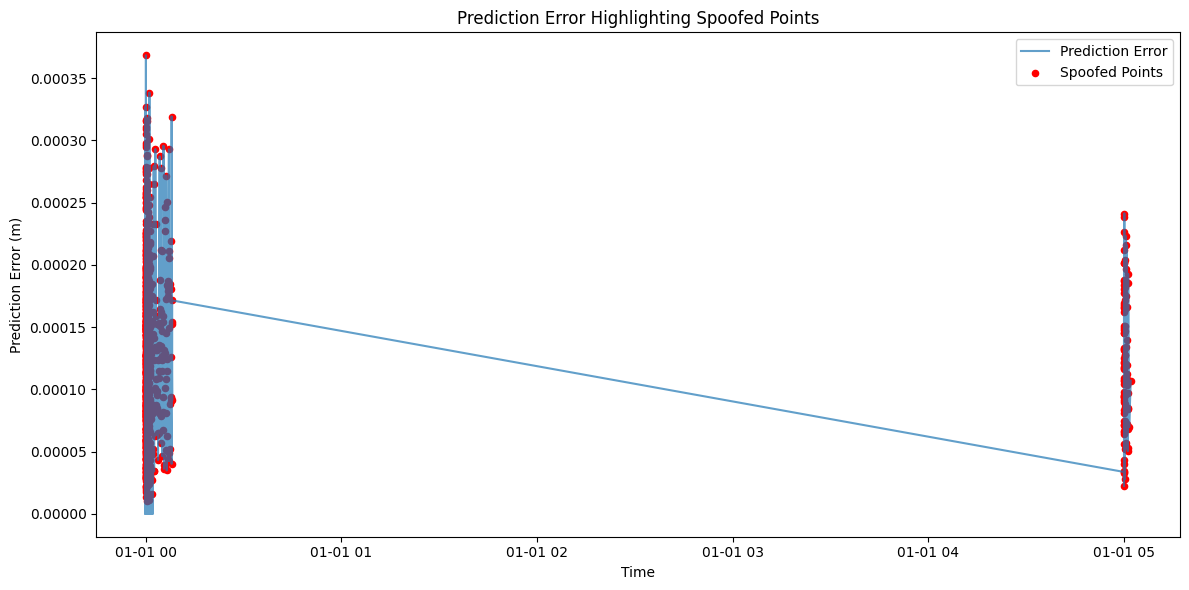

Interactive map saved as ./trajectory_map.html
Analysis completed. All available plots saved and interactive outputs generated where possible.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os


CSV_PATH = "/content/drive/MyDrive/gps_spoofing data.csv"
OUT_DIR = "."
os.makedirs(OUT_DIR, exist_ok=True)



df = pd.read_csv(CSV_PATH)

df.columns = [c.strip() for c in df.columns]


if 'BaseDateTime' in df.columns:
    df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'], errors='coerce')
else:
    raise KeyError("Expected column 'BaseDateTime' not found in CSV.")


print("Columns:", df.columns.tolist())
print(df.head())
print(df.info())
print(df.describe(include='all'))
print("Class distribution:\n", df['Label'].value_counts(dropna=False))


df['Label_str'] = df['Label'].apply(lambda v: str(v).strip())

def is_spoofed(v):
    s = str(v).strip().lower()
    if s in ('spoofed', 'spoof', '1', 'true', 'yes'):
        return True
    try:

        return float(v) == 1.0
    except Exception:
        return False

df['is_spoofed'] = df['Label'].apply(is_spoofed)


df = df.sort_values('BaseDateTime').reset_index(drop=True)


hist_cols = ['speed_calc', 'acceleration', 'delta_heading', 'prediction_error']
hist_present = [c for c in hist_cols if c in df.columns]
if hist_present:
    df[hist_present].hist(bins=30, figsize=(12, 8))
    plt.suptitle("Distribution of Navigation Features")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "histograms_features.png"))
    plt.show()
else:
    print("No histogram columns found among:", hist_cols)


plt.figure(figsize=(6,4))
sns.countplot(x='Label_str', data=df, order=df['Label_str'].value_counts().index)
plt.title("Number of Normal vs Spoofed Points (by Label values)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "spoofing_count.png"))
plt.show()


if ('LON' in df.columns) and ('LAT' in df.columns):
    plt.figure(figsize=(10, 6))
    unique_labels = df['Label_str'].unique().tolist()

    pal = sns.color_palette("Set1", n_colors=len(unique_labels))
    palette_dict = {lab: pal[i] for i, lab in enumerate(unique_labels)}
    sns.scatterplot(
        x='LON', y='LAT', hue='Label_str',
        palette=palette_dict, alpha=0.6, data=df
    )
    plt.title("Ship Trajectory with Spoofed Points Highlighted")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title='Label', loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "trajectory.png"))
    plt.show()
else:
    print("Missing LON/LAT columns for the trajectory scatter plot.")


ts_present = ('speed_calc' in df.columns) and ('prediction_error' in df.columns)
if ts_present:
    plt.figure(figsize=(12, 6))
    plt.plot(df['BaseDateTime'], df['speed_calc'], label='Speed (m/s)')
    plt.plot(df['BaseDateTime'], df['prediction_error'], label='Prediction Error (m)')
    plt.title("Speed and Prediction Error Over Time")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "time_series.png"))
    plt.show()
else:
    print("Missing 'speed_calc' or 'prediction_error' for time-series plot.")


corr_cols = [
    'speed_calc', 'acceleration', 'delta_heading', 'prediction_error',
    'speed_ma', 'acceleration_ma', 'delta_heading_ma'
]
corr_present = [c for c in corr_cols if c in df.columns]
if len(corr_present) >= 2:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[corr_present].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "correlation_heatmap.png"))
    plt.show()
else:
    print("Not enough columns for correlation heatmap. Present:", corr_present)

if 'prediction_error' in df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df['BaseDateTime'], df['prediction_error'], label='Prediction Error', alpha=0.7)

    if df['is_spoofed'].any():
        plt.scatter(
            df[df['is_spoofed']]['BaseDateTime'],
            df[df['is_spoofed']]['prediction_error'],
            color='red', label='Spoofed Points', s=20
        )
    plt.title("Prediction Error Highlighting Spoofed Points")
    plt.xlabel("Time")
    plt.ylabel("Prediction Error (m)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "rolling_pred_error.png"))
    plt.show()
else:
    print("prediction_error column not found — skipping pred error plot.")


if ('LAT' in df.columns) and ('LON' in df.columns):
    center = [df['LAT'].mean(), df['LON'].mean()]
    m = folium.Map(location=center, zoom_start=6)
    for _, row in df.iterrows():

        color = 'red' if row['is_spoofed'] else 'blue'
        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=str(row.get('Label', ''))
        ).add_to(m)
    map_path = os.path.join(OUT_DIR, "trajectory_map.html")
    m.save(map_path)
    print(f"Interactive map saved as {map_path}")
else:
    print("Missing LAT/LON — cannot build folium map.")

print("Analysis completed. All available plots saved and interactive outputs generated where possible.")


### Data preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/gps_spoofing data.csv")
df.isnull().sum()


,0
MMSI,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
speed_calc,0
acceleration,4889
delta_heading,0


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/gps_spoofing data.csv")
print(df.columns)


Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'speed_calc', 'acceleration', 'delta_heading', 'speed_ma',
       'acceleration_ma', 'delta_heading_ma', 'LAT_pred', 'LON_pred',
       'prediction_error', 'Label'],
      dtype='object')


In [ ]:
df.isnull().sum()


,0
MMSI,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
speed_calc,0
acceleration,4889
delta_heading,0


In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df.head(5)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,speed_calc,acceleration,delta_heading,speed_ma,acceleration_ma,delta_heading_ma,LAT_pred,LON_pred,prediction_error,Label
1045,270995,2020-01-01 00:00:03,35.09744,-90.10038,0.0,245.1,511.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Normal
1067,270995,2020-01-01 00:00:03,35.09744,-90.10038,0.0,245.1,511.0,0.0,-14.2,219.9,4.733333,-0.033333,78.900000,35.097472,-90.100590,0.000212,Spoofed
6265,270995,2020-01-01 05:00:03,35.09744,-90.10038,0.0,245.1,511.0,0.0,-9.3,46.4,7.933333,-5.833333,37.600000,35.097517,-90.100354,0.000081,Spoofed
2712,507027,2020-01-01 00:00:08,37.00643,-76.25625,0.1,308.3,511.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,37.006430,-76.256250,0.000000,Normal
2920,507027,2020-01-01 00:00:08,37.00648,-76.25620,0.1,308.3,511.0,0.1,0.1,307.1,3.800000,-2.766667,7.166667,37.006558,-76.256197,0.000078,Spoofed


In [ ]:
df.isnull().sum()


,0
MMSI,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
speed_calc,0
acceleration,0
delta_heading,0


##Normalisation and standarization

In [ ]:
print(df.head())

        MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
1045  270995 2020-01-01 00:00:03  35.09744 -90.10038  0.0  245.1    511.0   
1067  270995 2020-01-01 00:00:03  35.09744 -90.10038  0.0  245.1    511.0   
6265  270995 2020-01-01 05:00:03  35.09744 -90.10038  0.0  245.1    511.0   
2712  507027 2020-01-01 00:00:08  37.00643 -76.25625  0.1  308.3    511.0   
2920  507027 2020-01-01 00:00:08  37.00648 -76.25620  0.1  308.3    511.0   

      speed_calc  acceleration  delta_heading  speed_ma  acceleration_ma  \
1045         0.0           0.0            0.0  0.000000         0.000000   
1067         0.0         -14.2          219.9  4.733333        -0.033333   
6265         0.0          -9.3           46.4  7.933333        -5.833333   
2712         0.0           0.0            0.0  0.000000         0.000000   
2920         0.1           0.1          307.1  3.800000        -2.766667   

      delta_heading_ma   LAT_pred   LON_pred  prediction_error    Label  
1045  

In [ ]:

print(df['Label'].value_counts())


print(df['Label'].value_counts(normalize=True) * 100)


Label
Normal     5401
Spoofed     950
Name: count, dtype: int64
Label
Normal     85.041726
Spoofed    14.958274
Name: proportion, dtype: float64


In [ ]:
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])


In [ ]:
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

df['year'] = df['BaseDateTime'].dt.year
df['month'] = df['BaseDateTime'].dt.month
df['day'] = df['BaseDateTime'].dt.day
df['hour'] = df['BaseDateTime'].dt.hour
df['minute'] = df['BaseDateTime'].dt.minute
df['second'] = df['BaseDateTime'].dt.second
df['weekday'] = df['BaseDateTime'].dt.weekday


In [ ]:
print(df.head())

        MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
1045  270995 2020-01-01 00:00:03  35.09744 -90.10038  0.0  245.1    511.0   
1067  270995 2020-01-01 00:00:03  35.09744 -90.10038  0.0  245.1    511.0   
6265  270995 2020-01-01 05:00:03  35.09744 -90.10038  0.0  245.1    511.0   
2712  507027 2020-01-01 00:00:08  37.00643 -76.25625  0.1  308.3    511.0   
2920  507027 2020-01-01 00:00:08  37.00648 -76.25620  0.1  308.3    511.0   

      speed_calc  acceleration  delta_heading  ...   LON_pred  \
1045         0.0           0.0            0.0  ...   0.000000   
1067         0.0         -14.2          219.9  ... -90.100590   
6265         0.0          -9.3           46.4  ... -90.100354   
2712         0.0           0.0            0.0  ... -76.256250   
2920         0.1           0.1          307.1  ... -76.256197   

      prediction_error    Label  year  month  day hour  minute  second  \
1045          0.000000   Normal  2020      1    1    0       0       3  

#### Encoding

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = df.drop(columns=['Label', 'BaseDateTime']).columns

X = df[feature_cols]
y = df['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Encoder Y(normal/spoof)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [ ]:
print(y.head())

1045     Normal
1067    Spoofed
6265    Spoofed
2712     Normal
2920    Spoofed
Name: Label, dtype: object


In [ ]:
import numpy as np
import pandas as pd


X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)


print(X_scaled_df.head())


print(X_scaled_df.dtypes)

print("Mean of features:\n", X_scaled_df.mean())
print("Std of features:\n", X_scaled_df.std())


       MMSI       LAT       LON       SOG       COG   Heading  speed_calc  \
0 -4.323785  0.010839  0.120177 -0.480622  0.420321  0.917103   -0.298825   
1 -4.323785  0.010839  0.120177 -0.480622  0.420321  0.917103   -0.298825   
2 -4.323785  0.010839  0.120177 -0.480622  0.420321  0.917103   -0.298825   
3 -4.320854  0.151926  0.538283 -0.464336  0.998622  0.917103   -0.298825   
4 -4.320854  0.151930  0.538284 -0.464336  0.998622  0.917103   -0.267299   

   acceleration  delta_heading  speed_ma  ...  LAT_pred  LON_pred  \
0      0.000072       0.001355 -0.345794  ... -2.581339  2.839063   
1     -4.743706       3.518910  1.511186  ...  0.011244  0.119667   
2     -3.106769       0.743577  2.766609  ...  0.011247  0.119674   
3      0.000072       0.001355 -0.345794  ...  0.152255  0.537514   
4      0.033479       4.913775  1.145021  ...  0.152264  0.537515   

   prediction_error  year  month  day      hour    minute    second  weekday  
0         -0.365854   0.0    0.0  0.0 -0.12

In [ ]:
print("Unique labels in y_encoded:", np.unique(y_encoded))
print("First 10 labels:", y_encoded[:10])


Unique labels in y_encoded: [0 1]
First 10 labels: [0 1 1 0 1 1 1 1 1 1]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


In [ ]:

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


import numpy as np

print("\nTrain label distribution:", np.unique(y_train, return_counts=True))
print("Validation label distribution:", np.unique(y_val, return_counts=True))
print("Test label distribution:", np.unique(y_test, return_counts=True))


Train size: 4445
Validation size: 953
Test size: 953

Train label distribution: (array([0, 1]), array([3780,  665]))
Validation label distribution: (array([0, 1]), array([810, 143]))
Test label distribution: (array([0, 1]), array([811, 142]))


##Logistic Regression:is an supervised algorithm used for classifications problems

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)


lr_model.fit(X_train, y_train)


y_val_pred_lr = lr_model.predict(X_val)


print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_lr))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_lr))


Logistic Regression Validation Accuracy: 0.9307450157397692

Confusion Matrix:
 [[747  63]
 [  3 140]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       810
           1       0.69      0.98      0.81       143

    accuracy                           0.93       953
   macro avg       0.84      0.95      0.88       953
weighted avg       0.95      0.93      0.94       953



### Support Vector Machine (SVM) :is a supervised machine learning algorithm used for classification, regression, and outlier detection tasks.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42
)

svm_model.fit(X_train, y_train)


y_val_pred_svm = svm_model.predict(X_val)


print("SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_svm))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_svm))


y_test_pred_svm = svm_model.predict(X_test)
print("\nSVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))


SVM Validation Accuracy: 0.8793284365162645

Confusion Matrix:
 [[695 115]
 [  0 143]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92       810
           1       0.55      1.00      0.71       143

    accuracy                           0.88       953
   macro avg       0.78      0.93      0.82       953
weighted avg       0.93      0.88      0.89       953


SVM Test Accuracy: 0.8688352570828961


## XGBoost(eXtreme Gradient Boosting) is a framework that handle a complexe tasks of classification

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


xgb_model.fit(X_train, y_train)


y_val_pred_xgb = xgb_model.predict(X_val)


print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_xgb))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_xgb))


y_test_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Test Accuracy:", accuracy_score(y_test, y_test_pred_xgb))


XGBoost Validation Accuracy: 0.9958027282266527

Confusion Matrix:
 [[810   0]
 [  4 139]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       810
           1       1.00      0.97      0.99       143

    accuracy                           1.00       953
   macro avg       1.00      0.99      0.99       953
weighted avg       1.00      1.00      1.00       953


XGBoost Test Accuracy: 0.9979013641133263


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:10:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Select XGBoost and moving to test

In [ ]:

y_test_pred = xgb_model.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix


print("Confusion Matrix (Test):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


print("\nClassification Report (Test):")
report = classification_report(y_test, y_test_pred)
print(report)


test_accuracy = (y_test_pred == y_test).mean()
print("\nXGBoost Test Accuracy:", test_accuracy)


Confusion Matrix (Test):
[[811   0]
 [  2 140]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       811
           1       1.00      0.99      0.99       142

    accuracy                           1.00       953
   macro avg       1.00      0.99      1.00       953
weighted avg       1.00      1.00      1.00       953


XGBoost Test Accuracy: 0.9979013641133263


In [ ]:
y_test_pred = xgb_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Confusion Matrix (Test):
[[675   0]
 [ 16  59]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       675
           1       1.00      0.79      0.88        75

    accuracy                           0.98       750
   macro avg       0.99      0.89      0.93       750
weighted avg       0.98      0.98      0.98       750



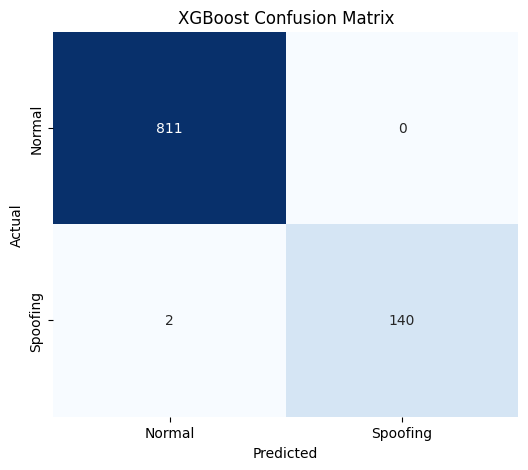

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_test_pred = xgb_model.predict(X_test)


cm = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Spoofing'],
            yticklabels=['Normal', 'Spoofing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')


plt.savefig("xgboost2.png", dpi=300, bbox_inches='tight')
plt.show()
